<a href="https://colab.research.google.com/github/Seungwon-hub/ESAA/blob/main/ESAA_YB_Week10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 6. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

### 규제 선형 모델의 개요

회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 수 있어야 함. 비용 함수는 학습 데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않ㄷ록 하는 방법이 서로 균형을 이뤄야 함.

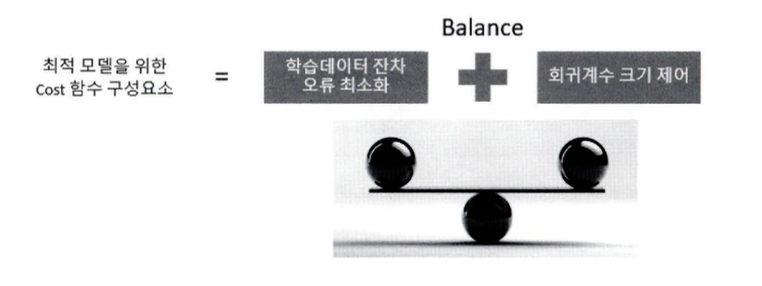

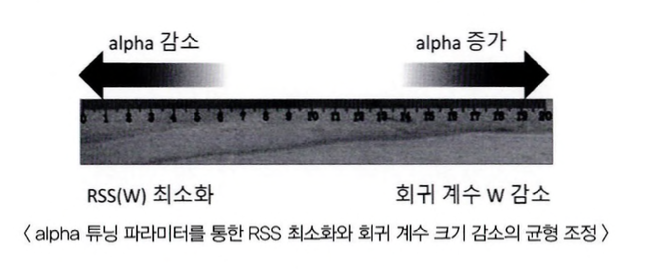

### 릿지 회귀

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

%matplotlib inline

data_url="http://lib.stat.cmu.edu/datasets/boston"
raw_df=pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data=np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target=raw_df.values[1::2, 2]

bostonDF=pd.DataFrame(data, columns=['CRIM','ZN','INDUS','CHAS', 'NOX','RM','AGE','DIS',
                                     'RAD','TAX','PTRATIO','B','LSTAT'])

bostonDF['PRICE']=target
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE: 5.518


In [ ]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함
for alpha in alphas:
  ridge = Ridge(alpha = alpha)

  # cross_val_score를 이용해 5폴드의 평균 RMSE를 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
  avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
  print('alpha {0}일 때 5 folds의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE: 5.829
alpha 0.1일 때 5 folds의 평균 RMSE: 5.788
alpha 1일 때 5 folds의 평균 RMSE: 5.653
alpha 10일 때 5 folds의 평균 RMSE: 5.518
alpha 100일 때 5 folds의 평균 RMSE: 5.330


- alpha가 100일 때 평균 RMSE가 5.330으로 가장 좋음

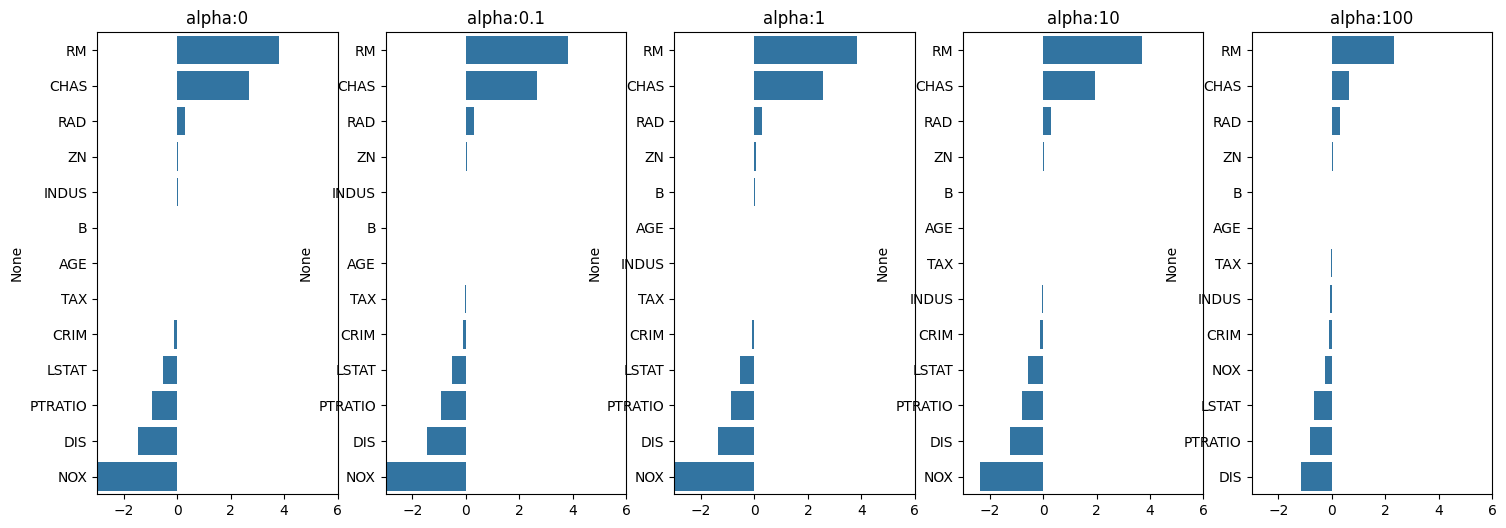

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, ax = plt.subplots(figsize=(18,6), nrows=1, ncols=5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_data, y_target)

  # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
  coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
  colname = 'alpha:'+str(alpha)
  coeff_df[colname] = coeff

  # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending=False)
  ax[pos].set_title(colname)
  ax[pos].set_xlim(-3,6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=ax[pos])

# for문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

- alpha 값을 계속 증가시킬수록 회귀 계수 값은 지속적으로 작아짐
- NOX 피처의 경우 alpha값을 계속 증가시킴에 따라 회귀 계수가 크게 작아짐

In [ ]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


- alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있음
- 하지만 릿지 회귀는 회귀 계수를 0으로 만들지는 않음

### 라쏘 회귀

- w의 절댓값에 패널티를 부여하는 L1규제를 선형 회귀에 적용한 것
- 라쏘 회귀 비용함수의 목표는 RSS + alpha*||W|| 식을 최소화하는 W를 찾는 것
- L2 규제가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함 -> 피처 선택의 특성


In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):
  coeff_df = pd.DataFrame()
  if verbose : print('#######', model_name , '#######')
  for param in params:
    if model_name == 'Ridge' : model = Ridge(alpha=param)
    elif model_name == 'Lasso' : model = Lasso(alpha=param)
    elif model_name == 'ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n,
                                     scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    model.fit(X_data_n, y_target_n)
    if return_coeff:
      # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
      coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
      colname = 'alpha:'+str(param)
      coeff_df[colname] = coeff

  return coeff_df

# end of get_linear_regre_eval

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

####### Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


In [ ]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


- alpha 크기가 증가함에 따라 일부 피처의 회귀 계수는 아예 0으로 바뀌고 있음

### 엘라스틱넷 회귀
- L2 규제 + L1 규제
- 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강함
- L1, L2 규제가 결합된 규제로 인해 수행시간이 상대적으로 오래 걸림

In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터 값들을 정의하고 get_linear_reg_eva() 함수 호출
# l1_ratio는 0.7로 고정

elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                       X_data_n=X_data, y_target_n=y_target)

####### ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [ ]:
# 반환된 coeff_elastic_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


### 선형 회귀 모델을 위한 데이터 변환
- 선형 회귀 모델은 피처값과 타깃값의 분포가 정규분포 형태를 매우 선호
- 타깃값의 경우 정규 분포 형태가 아니라 특정값의 분포가 치우친 왜곡된 형태의 분포일 경우 예측 성능에 부정적인 영향을 미칠 가능성 큼
- 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적

1. **StandardScaler**: 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터 세트로 변환
2. **MinMaxScaler**: 최솟값이 0이고 최댓값이 1인 값으로 정규화
3. 스케일링/정규화 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환하는 방법
4. **로그 변환**: 원래 값에 log함수 적용하면 보다 정규 분포에 가까운 형태로 값이 분포됨

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2 이상 부여하지 않음
def get_scaled_data(method='None', p_degree=None, input_data=None):
  if method == 'Standard':
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax':
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log':
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data

  if p_degree != None:
    scaled_data = PolynomialFeatures(degree=p_degree,
                                     include_bias=False).fit_transform(scaled_data)

  return scaled_data

In [ ]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규 분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그 변환
scaled_methods=[(None, None), ('Standard', None), ('Standard',2),
                ('MinMax', None), ('MinMax', 2), ('Log',None)]

for scale_method in scaled_methods:
  X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                  input_data=X_data)
  print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
  get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                      y_target_n=y_target, verbose=False, return_coeff=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 4.770

## 7. 로지스틱 회귀


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3,
                                                    random_state=0)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행
# solver 인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds),
                                                  roc_auc_score(y_test, lr_preds_proba)))

accuracy: 0.977, roc_auc:0.995


In [ ]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

# 여러 개의 solver 값별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
  lr_clf = LogisticRegression(solver=solver, max_iter=600)
  lr_clf.fit(X_train, y_train)
  lr_preds = lr_clf.predict(X_test)
  lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

  # accuracy와 roc_auc 측정
  print('solver：{0}, accuracy： {1:.3f}, roc_auc：{2:.3f}'.format(solver,
                                                                accuracy_score(y_test, lr_preds),
                                                                roc_auc_score(y_test , lr_preds_proba)))

solver：lbfgs, accuracy： 0.977, roc_auc：0.995
solver：liblinear, accuracy： 0.982, roc_auc：0.995
solver：newton-cg, accuracy： 0.977, roc_auc：0.995
solver：sag, accuracy： 0.982, roc_auc：0.995
solver：saga, accuracy： 0.982, roc_auc：0.995


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'solver':['liblinear','lbfgs'],
          'penalty':['l2','l1'],
          'C':[0.01, 0.1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,
                                                  grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

## 8. 회귀 트리

트리 기반의 회귀는 회귀 트리를 이용함. 즉, 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측을 하는 것임. 회귀 트리는 분류 트리와 크게 다르지 않지만 리프 노드에서 예측 결정 값을 만드는 과정에 차이가 있는데, 분류 트리가 특정 클래스 레이블을 결정하는 것과 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

data_url="http://lib.stat.cmu.edu/datasets/boston"
raw_df=pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data=np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target=raw_df.values[1::2, 2]

bostonDF=pd.DataFrame(data, columns=['CRIM','ZN','INDUS','CHAS', 'NOX','RM','AGE','DIS',
                                     'RAD','TAX','PTRATIO','B','LSTAT'])

bostonDF['PRICE'] = target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores:', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores: [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE: 4.423


< 그림 >

데이터 세트의 X 피처를 결정 트리 기반으로 분할하면 X값의 균일도를 반영한 지니 계수에 따라 왼쪽과 같이 분할할 수 있음. 루트 노드를 split0 기준으로 분할하고 이렇게 분할된 규칙 노드에서 다시 분할.

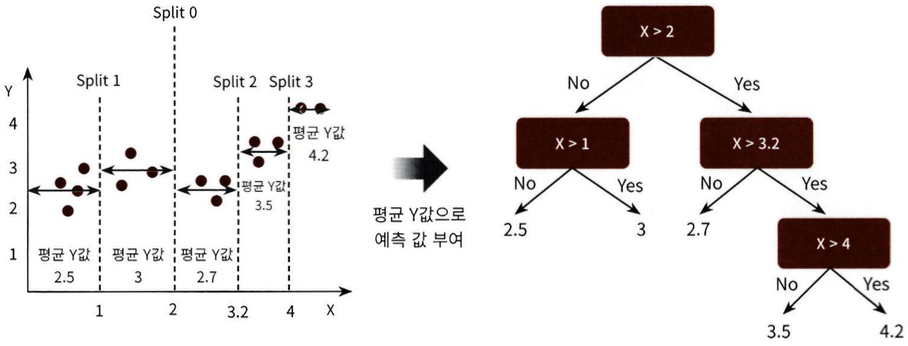

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 보스턴 데이터 세트 로드
data_url="http://lib.stat.cmu.edu/datasets/boston"
raw_df=pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data=np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target=raw_df.values[1::2, 2]

bostonDF=pd.DataFrame(data, columns=['CRIM','ZN','INDUS','CHAS', 'NOX','RM','AGE','DIS',
                                     'RAD','TAX','PTRATIO','B','LSTAT'])

bostonDF['PRICE']=target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores:', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores: [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE: 4.423


In [5]:
def get_model_cv_prediction(model, X_data, y_target):
  neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
  rmse_scores = np.sqrt(-1 * neg_mse_scores)
  avg_rmse = np.mean(rmse_scores)
  print('#####', model.__class__.__name__, '#####')
  print('5 교차 검증의 평균 RMSE: {0:.3f}'.format(avg_rmse))

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
  get_model_cv_prediction(model, X_data, y_target)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

- 회귀 트리 Regressor 클래스는 회귀 계수를 제공하는 coef_ 속성 없음
- 대신 feature_importance_를 이용해 보스턴 주택 가격 모델의 피처 중요도 시각화

<Axes: xlabel='None', ylabel='None'>

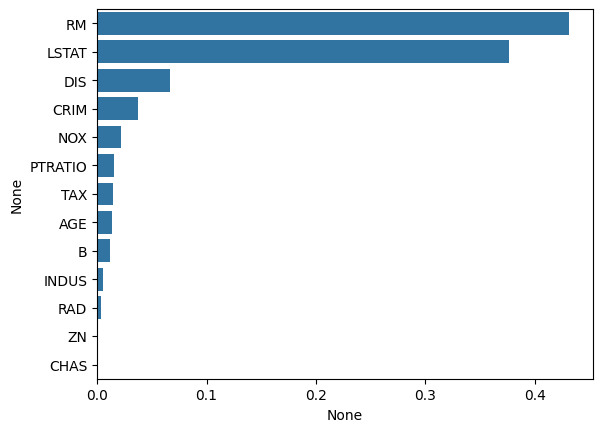

In [7]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index = X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

(100, 2)


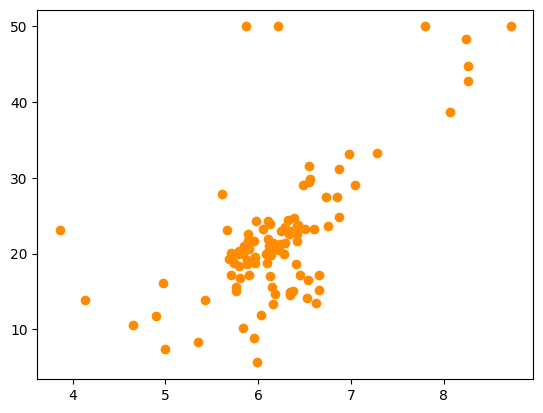

In [8]:
bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkorange')

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth = 2)
rf_reg7 = DecisionTreeRegressor(max_depth = 7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5 ~ 8.5까지의 100개의 데이터 세트로 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

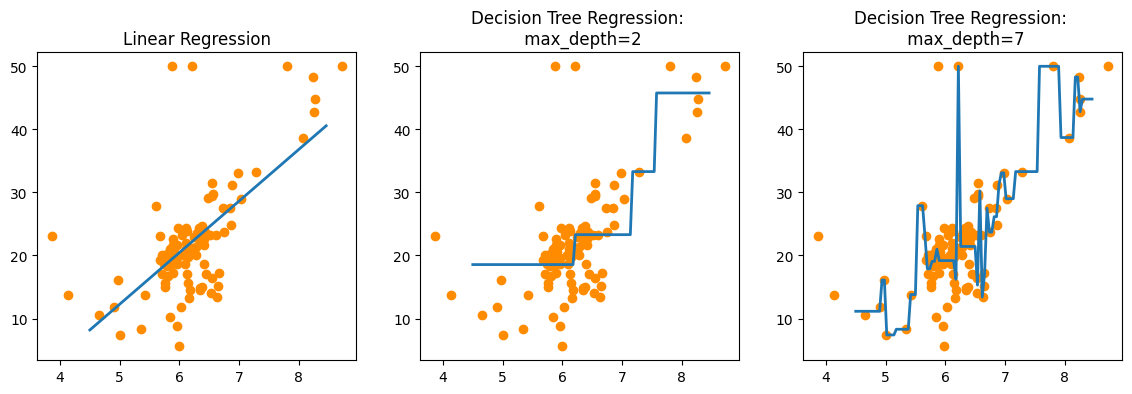

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축 값을 4.5 ~ 8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

# DecisionTreeRegresor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:3', linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)

- max_depth =7인 경우에는 학습 데이터 세트의 이상치 데이터도 학습하면서 복잡한 계단 형태의 회귀선을 만들어 과적합이 되기 쉬운 모델이 되었음을 알 수 있음